# The FeatureSpace Intern Recruitment Challenge: Compromise point detection

## In this solution, I tackle the problem by inspecting the porportion of the accounts which transacted with a merchant on a date which will commit a fraud.
For all of the transactions of each merchant on each date, a score will be given depending on the ratio of number the accounts involved in these transactions that become defrauded in the future and the number of all accounts involved.
If score for a day for a merchant is too high, it represent that it is highly possible the merchant is compromised on that day, i.e. that is a harvest day.

#### Pre-processing data

In [1]:
'''Import all relative library'''
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [2]:
'''Do data preprocessing'''
# read raw data
raw_data = pd.read_csv("input.csv")

# convert date data to formal format
raw_data['date'] = pd.to_datetime(raw_data['date'])  

# convert account and merchant into no.'s
raw_data.loc[:, ['merchant', 'account']] = raw_data.loc[:, ['merchant', 'account']].applymap(lambda x: int(x[1:]))

# Gather names of merchants and accounts
merchants = set(raw_data['merchant']) 
accounts = set(raw_data['account'])

## Q1. Calculate score for the transactions of each merchant on each day
#### harvest score = no. of undefrauded-accounts involved in the transactions that were defrauded in the future / no. of un-defrauded-accounts involved in the transactions

In [97]:
'''Get two vital sets of accounts: completely undefrauded, and will-be-defrauded accounts
for each day'''
# get all defrauded account for each day
defrauded_account_data = raw_data.loc[raw_data.fraud==True].groupby(by='date')['account']

# get a dataframe in which stores, for each date, 
# a set of accounts that have not committed a fraud (assuminly completely undefrauded)
# and a set of accounts that will become defrauded in the future
date_range = pd.date_range('2015-01-01', '2015-01-30') # the date range of the database

# get undefrauded account set for each day
defrauded_accounts = dict()
will_be_defrauded_accounts = dict()
defrauded_account_set = set()
will_be_defrauded_account_set = set()
for d in range(30):
    # update defrauded account set
    # NB, for accounts that commit a fraud on the day we investigate, we consider them as defrauded accounts
    defrauded_account_set |= set(defrauded_account_data.get_group(date_range[d]))
    defrauded_accounts[date_range[d]] = set(defrauded_account_set)
    
    # update will be defrauded account set
    # NB, we will not know for the account on the last date of the database whether they will be defrauded or not
    if d==0:
        will_be_defrauded_accounts[date_range[-1]] = will_be_defrauded_account_set
    else: 
        will_be_defrauded_account_set |= set(defrauded_account_data.get_group(date_range[-d]))
        will_be_defrauded_accounts[date_range[-d-1]] = set(will_be_defrauded_account_set)

In [106]:
'''Get harvest score for each merchant on each date'''
# group data by merchant, date, account
merchant_harvest_score = raw_data.groupby(by=['merchant', 'date'])

# get score for each merchant date
def get_harvest_score(x):
    cur_date = x['date'].iloc[0]
    undefrauded_account_set = set(x['account']) - defrauded_accounts[cur_date]
    to_be_defruaded_account_set = undefrauded_account_set & will_be_defrauded_accounts[cur_date]
    
    if len(undefrauded_account_set) > 3:
        score = len(to_be_defruaded_account_set) / float(len(undefrauded_account_set))
    else:
        score = 0
    
    return score
merchant_harvest_score = merchant_harvest_score.apply(get_harvest_score)

* Aparantly, we can now locate the exploit point of compromise, which last from __01-21 to 01-23__
* Further analysis would be to analyze the common point of the defrauded accounts and thereby get the point of compromise

In [107]:
temp_df = df()
for row in merchant_harvest_score.items():
    temp_df.loc[row[0][1], row[0][0]] = row[1]

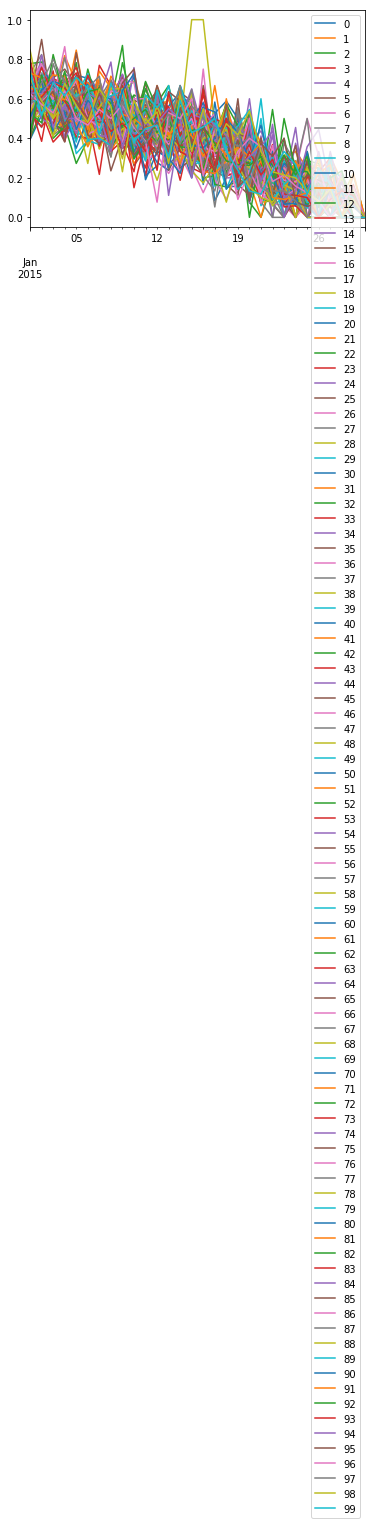

In [108]:
temp_df.plot()
plt.show()

In [ ]:
for m in merchants:
    temp_df.loc[:,m].plot(title=str(m), ylim=(0,1))
    plt.show()

## Answer: The exploitation lasted from Jan 21 to Jan 23

In [67]:
'''Answer for exploitation period of compromise'''
exp_dates = pd.date_range('21/1/2015', periods=3)

## Q2. Common point of compromise
#### Analysis of defrauded accounts which commited a number of fraudulant transaction during the expolitation period

In [95]:
'''Get the defrauded acccounts set'''
# this thresh indicate how many fraudulant transactions are needed to determine 
# if an account is non-oppotunisticly defrauded
fraud_account_thresh = 2

# get all fraudulant transactions during the exp period
defraud_data = data_during_exp[data_during_exp.fraud == True]

# get trasaction data during the exp period
data_during_exp = raw_data.loc[(raw_data.date >= exp_dates[0]) & (raw_data.date <= exp_dates[-1])]

# collect defrauded_accounts that at least commit fraud_account_thresh fraud during exp
defrauded_accounts = set()
account_fraud = defraud_data.groupby(by='account')['fraud'].count()
for account in accounts:
    try:
        if account_fraud[account] >= fraud_account_thresh:
            defrauded_accounts.add(account)
    except:
        pass

# count how many defrauded accounts are captured
defrauded_accounts_no = len(defrauded_accounts)
print(defrauded_accounts_no, " bad accounts captured")

57  bad accounts captured


most relative merchant is:  18  which correlates with:  1.0  defrauded accounts


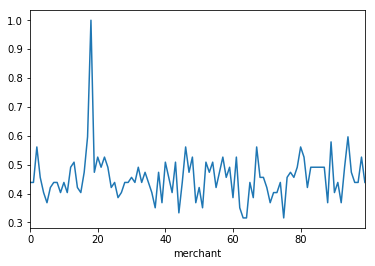

In [183]:
'''Analyze the correlation between the defrauded accounts and each merchant'''
# get a list of merchants that each account has had transaction(s) before
# get transactions before date of exploitation, and only of defrauded accounts
data_before_exp = raw_data.loc[(raw_data.date < exp_dates[0]) & raw_data.account.isin(defrauded_accounts)]

# get no of defrauded accounts each merchant has had transactions with
account_merchant = data_before_exp.groupby(by='merchant')['account'].apply(lambda x: len(set(x)) / defrauded_accounts_no)

# display result
print("most relative merchant is: ", account_merchant.argmax(), " which correlates with: ", \
      account_merchant.max(), " defrauded accounts")
account_merchant.plot()
plt.show()

### Simple analysis
* The analysis show that, for those __highly confident defrauded accounts__ (which committed at least 2 fraud during the exploit period) all had their information stored in __M18__, while comparitively, for most of the other merchants, only around half of these defrauded accounts have had transaction with them respectively.
* It can be concluded with high confidence that __M18 is the common point of compromise__, from the aforementioned extreme correlation

## Answer: M18 is the common point of compromise

In [186]:
'''Answer for common point of compromise'''
compromised_merchant = 18

## Q3. Harvest period
#### analysis of the transaction activity between defrauded accounts and compromised merchant

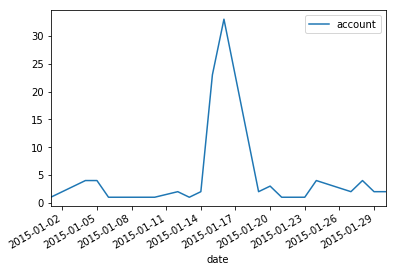

In [196]:
'''Analyze behavior of defrauded accounts with compromised merchant'''
# get defrauded accounts' activity with compromise merchant
# get only data related to defrauded accounts
defrauded_accounts_data = raw_data[raw_data.account.isin(defrauded_accounts) & \
                                   (raw_data.merchant == compromised_merchant)]
# count transactions of defrauded accounts with each merchants on each day
defrauded_accounts_data = defrauded_accounts_data.loc[:, ['date', 'account']]
transaction_no_data = defrauded_accounts_data.groupby(by='date')
transaction_no_data = transaction_no_data.count()

# display data
transaction_no_data.plot()
plt.show()

### Simple analysis
* The defrauded accounts all had __unusually large number of transactions__ with the compromised merchant between __Jan 15 and Jan 16__, which according to theory, represents the harvest period

## Answer: The harvest lasted from Jan 15 to Jan 16

## Q4. What are the dates of compromise
#### Analyze the overall behavior of defrauded accounts in two respects:
1. The activity with compromised merchant
2. The fraud commited each day over the month

In [198]:
'''Analyze overall behavior of defrauded accounts'''
# get defrauded accounts' fraudulant transaction no on each day
# get only fraud related to defrauded accounts
defrauded_accounts_data = raw_data[raw_data.account.isin(defrauded_accounts) & raw_data.fraud]
# count fruadulant transactions of defrauded accounts with each merchants on each day
defrauded_accounts_data = defrauded_accounts_data.loc[:, ['date', 'merchant']]
fraud_no_data = defrauded_accounts_data.groupby(by='date')
fraud_no_data = fraud_no_data.count()

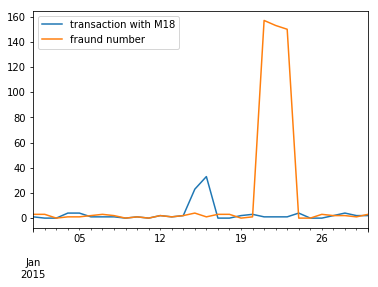

In [199]:
'''Data visualization'''
# combine both data and draw them out
# first, reindex each data so that their shapes match each other
new_index = pd.date_range('2015-01-01', periods=30)
transaction_no_data = transaction_no_data.reindex(new_index, fill_value=0)
fraud_no_data = fraud_no_data.reindex(new_index, fill_value=0)
# do the concatenation
defrauded_account_activity = pd.concat([transaction_no_data, fraud_no_data], axis=1)
defrauded_account_activity = defrauded_account_activity.rename(columns={'merchant': 'fraund number', 'account': 'transaction with M18'})
# display the graph
defrauded_account_activity.plot()
plt.show()

### Simple comments:
* The graph above matches perfectly with theory (according to the document of the problem)
* The match, on the other hand, validated our previous data analysis

## Answer: Dates of Compromise are: Jan 15, 16, 21, 22, 23